# Doctor Agent Simulation

This notebook is dedicated to setting up and simulating the interactions of the Doctor agent within our healthcare simulation environment. The Doctor agent plays a crucial role in diagnosing, managing treatment plans, and interacting with other healthcare professionals and patients.

## Objective
The main objective of this notebook is to implement and test the decision-making algorithms that empower the Doctor agent to perform its duties realistically and effectively in various healthcare scenarios.


# Environment Setup

In this section, we configure the necessary libraries and frameworks required for the simulation. This includes setting up the simulation environment and importing any necessary data models or agent frameworks.

## Dependencies
- Import all required Python libraries and any external frameworks needed for the agent to function.
- Ensure that all paths to additional scripts and data files are correctly set up for seamless integration.


In [1]:
import glob
import autogen
from autogen.graph_utils import visualize_speaker_transitions_dict
from autogen.agentchat.groupchat import GroupChat
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

In [2]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list, "cache_seed": 42}

# Doctor Agent Configuration

## Agent Initialization
Here we initialize the Doctor agent, setting up its attributes and capabilities based on predefined models that mimic real-life doctor responsibilities and decision-making processes.

## Capabilities
- **Diagnosis**: Ability to analyze patient data and symptoms to make medical diagnoses.
- **Treatment Planning**: Formulate and update treatment plans based on patient progress and new information.
- **Interaction**: Communicate effectively with patients and other healthcare agents (nurses, specialists) to coordinate care.


In [3]:
nurse = autogen.AssistantAgent(
    name="Nurse",
    llm_config=llm_config,
    system_message="""Nurse. You are a critical link between patients and the medical team. Your responsibilities include monitoring patient conditions, administering medications, and reporting vital signs to the Physicians.
    You assist in performing diagnostic tests and managing patient care logistics. Collect detailed patient information to update the Electronic Medical Records accurately and facilitate effective treatment planning by the Physicians.
    Respond to Physician directives by collecting specific patient data or performing necessary medical tasks. Communicate effectively with Patients to understand their concerns and symptoms, providing comfort and explaining treatment procedures.
    """
)

patient_2 = autogen.AssistantAgent(
    name="Patient2",
    llm_config=llm_config,
    system_message="""Patient. Communicate your symptoms, health history, and current concerns with Doctors and Nurses, understanding that your ability to articulate these may vary.
    Express how you feel about the treatments you receive and any difficulties you encounter in managing your health.
    React to inquiries from healthcare professionals based on your understanding and emotional state at the time. Engage with your care to different extents, depending on your personal health beliefs and experiences.
    """
)

## Configuration of the Doctor Agent

Here we outline the setup for the 'Doctor' agent, including:
- **Attributes**: Such as specialization, years of experience, and availability.
- **Capabilities**: Highlighting the range of medical procedures and diagnoses the doctor can perform.


In [4]:
physician_rag = RetrieveAssistantAgent(
    name="Doctor",
    human_input_mode="NEVER",
    llm_config=llm_config,
    code_execution_config=False,
    system_message="""
    You gather detailed health information through direct patient interactions, assessments from Nurses, and analysis of Electronic Medical Records. Based on this comprehensive data, develop and adjust treatment plans as necessary.
    When information is insufficient or symptoms are unclear, issue specific directives to Nurses to obtain further data, order additional diagnostic tests, or ask Patients for more detailed accounts of their symptoms.
    Engage in discussions with other healthcare professionals to coordinate care and ensure all aspects of the patient's health are addressed. Prioritize patient safety and treatment efficacy.
    In the healthcare setting, time can be of the essence so concision and clarity is key. However, show empathy towards patients.
    """,
    description="Doctor. You are responsible for diagnosing, treating, and overseeing the care of your patients."
)

emr_manager = RetrieveUserProxyAgent(
    name="EMR_Manager",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "qa",
        "docs_path": glob.glob("./emr_db/*"),
        "custom_text_types": ["non-existent-type"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "vector_db": "chroma",  # to use the deprecated `client` parameter, set to None and uncomment the line above
        "overwrite": True,  # set to True if you want to overwrite an existing collection
        "collection_name": "test",
    },
    code_execution_config=False,
    description="""EMR Agent. You store, manage, and retrieve patient health records. Receive updates from healthcare providers and log every interaction with timestamp and provider details.
    Provide medical history, test results, and other critical information upon request from authorized personnel only, ensuring compliance with privacy standards.
    """
)

c:\Users\khngu\OneDrive\Documents\GitHub\High-Risk-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


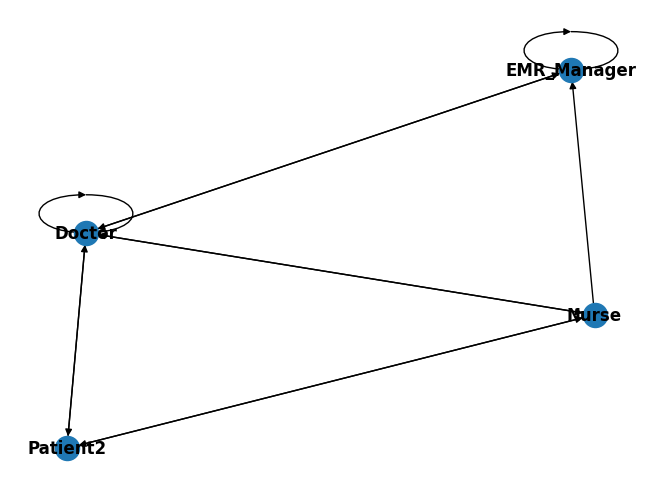

In [5]:
agents = [physician_rag, nurse, patient_2, emr_manager]

allowed_speaker_transitions_dict = {
    patient_2:    [physician_rag, nurse],
    physician_rag:[physician_rag, nurse, patient_2, emr_manager],
    nurse:        [physician_rag, patient_2, emr_manager],
    emr_manager:  [physician_rag, emr_manager]
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

# Simulation Scenarios

This section describes several scenarios that the Doctor agent might encounter. These are scripted events that test the agent's responses to typical healthcare situations, such as emergency responses, routine check-ups, or complex case management.

## Example Scenario: Managing a Cardiac Emergency
- **Situation**: A patient presents with symptoms of a heart attack.
- **Task**: Diagnose the condition, decide on the immediate action, and coordinate with other agents for treatment.
- **Expected Behavior**: The agent should quickly recognize the emergency, prescribe necessary interventions, and ensure follow-up care is arranged.


In [7]:
groupchat = GroupChat(
    agents=agents,
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed",
)

manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config=llm_config,
    code_execution_config=False,
)

qa_problem = "Give me 3 potential diagnoses for Patient3"
# qa_problem = "What are the Memorial Hospital's policies on patient privacy?"

physician_rag.reset()
emr_manager.initiate_chat(
    manager,
    message=emr_manager.message_generator,
    problem=qa_problem,
    search_string="Patient3",
)

Trying to create collection.


2024-04-30 06:22:33,593 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 3 chunks.
2024-04-30 06:22:33,595 - autogen.agentchat.contrib.vectordb.chromadb - INFO - No content embedding is provided. Will use the VectorDB's embedding function to generate the content embedding.
Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3


VectorDB returns doc_ids:  [['bf731696']]
Adding content of doc bf731696 to context.
EMR_Manager (to chat_manager):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: Give me 3 potential diagnoses for Patient3

Context is: Patient: Patient3
DOB: 11/05/1985

MRN (Medical Record Number): 1234567
Attending Physician:  Dr. Emily Smith

-----------Chief Complaint-----------

Persistent cough for the past 3 weeks
Shortness of breath with exertion
Occasional chest tightness
-----------Vitals (Today's Visit)-----------

Date: 05/30/2024
Time: 10:15 AM
BP: 130/85 mmHg
HR: 82 bpm
Temp: 98.7 °F (37.1 °C)
RR: 18 breaths/min
Weight: 155 lbs (70 kg)
-----------Medical History-----------

Conditions:
Asthma (diagnosed at age 10)
Seasonal Allerg

ChatResult(chat_id=None, chat_history=[{'content': "You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the\ncontext provided by the user.\nIf you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.\nYou must give as short an answer as possible.\n\nUser's question is: Give me 3 potential diagnoses for Patient3\n\nContext is: Patient: Patient3\nDOB: 11/05/1985\n\nMRN (Medical Record Number): 1234567\nAttending Physician:  Dr. Emily Smith\n\n-----------Chief Complaint-----------\n\nPersistent cough for the past 3 weeks\nShortness of breath with exertion\nOccasional chest tightness\n-----------Vitals (Today's Visit)-----------\n\nDate: 05/30/2024\nTime: 10:15 AM\nBP: 130/85 mmHg\nHR: 82 bpm\nTemp: 98.7 °F (37.1 °C)\nRR: 18 breaths/min\nWeight: 155 lbs (70 kg)\n-----------Medical History-----------\n\nConditions:\nAsthma (diagnosed at age 10)\nSeasonal Allergies\nMedications:\nAlbuterol inhal

# Conclusion and Future Work

In this notebook, we have set up and tested the Doctor agent within our healthcare simulation environment. The results indicate areas of strength in the agent's capabilities as well as opportunities for improvement.

## Next Steps
- **Enhancing Decision Algorithms**: Based on test results, refine the decision-making algorithms to handle complex cases more effectively.
- **Integration with Other Agents**: Continue to work on integrating the Doctor agent more seamlessly with other types of agents like Nurses and Administrative staff for a more cohesive simulation environment.
